# List of topics for the final project



## Project 5 algorithmic fairness
Algorithm fairness is becoming a fundamental topic in ML. It is a complex ethical task to define what fairness is/means. Once we have defined quantitatively what fairness is then, from a mathematical perspective, the problem of  algorithmic fairness is very clear: it is a multi-objective optimization problem. There are multi objectives that we aim to optimize during data fitting, e.g., accuracy and fairness.

The goal of this project is to implement from scratch the "fair" **linear and nonlinear SVM** described in the following paper (see in particular Appendix A that reports the optimization problem)  

["Fairness Constraints: Mechanisms for Fair Classification"](https://arxiv.org/pdf/1507.05259.pdf)

and reproduce the experiments reported in the paper. In particular, apply your method to the Adult and Bank 
data sets.

Your notebook must include:
* a description (summary) of the algorithm presented in the above paper (focusing on SVM), similar to the theoretical details of logistic regression I wrote at the beginning of the notebook for e-tivity Task A (week 1&2). The reader must understand from your explanation the difference between standard SVM and the "fair" SVM.
* You implementation of the "fair" **linear and nonlinear SVM** using CVXOPT to solve data fitting (as I have shown in Week 3 webinar, see also example below). You should implement it as a Python class (similar to logistic regression class for E-tivity 1).
* A test of the input-output behavior of your algorithm. More clearly, you have to replicate the experiment results you find in Section 4.1 for Synthetic Data and Section 4.2 of the above paper for the Adult and Bank data sets.


Resources:
* Week 3 webinar slides with the details of the SVM algorithm;
* [Example](https://xavierbourretsicotte.github.io/SVM_implementation.html) about how to use the library CVXOPT to implement data fitting for standard SVM
* [fairness-in-machine-learning](https://towardsdatascience.com/a-tutorial-on-fairness-in-machine-learning-3ff8ba1040cb)
* (Optional) Multi-objective optimization and Pareto optimality see Book chapter 12 (of our Module's book).

**How to approach the problem** (this is just a suggestion).

You can start implementing linear SVM and apply it to the Synthetic Data experiment in Section 4.1 so that you can plot the classification line for standard linear SVM versus fair linear SVM.


In [1]:
import numpy as np
from sklearn import datasets
import pandas as pd 
from sklearn import preprocessing

from sklearn import svm
import cvxopt
from sklearn.metrics import accuracy_score

## for synthetic data
import math
import matplotlib.pyplot as plt # for plotting stuff
from random import seed, shuffle
from scipy.stats import multivariate_normal # generating synthetic data

import warnings
warnings.filterwarnings('ignore')

In [2]:
def linear_kernel(**kwargs):
    def f(x1, x2):
        return np.dot(x1, x2)
    return f


def compute_p_rule(print_string, x_control, class_labels):

    try:
        """ Compute the p-rule based on Doctrine of disparate impact """
        non_prot_all = sum(x_control == 1.0) # non-protected group
        prot_all = sum(x_control == 0.0) # protected group
        non_prot_pos = sum(class_labels[x_control == 1.0] == 1.0) # non_protected in positive class
        prot_pos = sum(class_labels[x_control == 0.0] == 1.0) # protected in positive class
        frac_non_prot_pos = float(non_prot_pos) / float(non_prot_all)
        frac_prot_pos = float(prot_pos) / float(prot_all)
        p_rule = (frac_prot_pos / frac_non_prot_pos) * 100.0
        #print ()
        #print(("Total data points: %d" % (len(x_control))))
        #print(("# non-protected examples: %d" % (non_prot_all)))
        #print(("# protected examples: %d" % (prot_all)))
        #print(("Non-protected in positive class: %d (%0.0f%%)" % (non_prot_pos, non_prot_pos * 100.0 / non_prot_all)))
        #print(("Protected in positive class: %d (%0.0f%%)" % (prot_pos, prot_pos * 100.0 / prot_all)))
        print(("P-rule is: %0.0f%%" % ( p_rule )))
        return p_rule
    except ZeroDivisionError:
        print("p_rule divided by 0")
    
    return np.NaN


In [3]:
# Hide cvxopt output
cvxopt.solvers.options['show_progress'] = False #True
cvxopt.solvers.options['abstol'] = 1e-10
cvxopt.solvers.options['reltol'] = 1e-10
cvxopt.solvers.options['feastol'] = 1e-10

In [4]:
class SupportVectorMachine(object):
    """The Support Vector Machine classifier.
    Uses cvxopt to solve the quadratic optimization problem.

    Parameters:
    -----------
    C: float
        Penalty term.
    kernel: function
        Kernel function. Can be either polynomial, rbf or linear.
    power: int
        The degree of the polynomial kernel. Will be ignored by the other
        kernel functions.
    gamma: float
        Used in the rbf kernel function.
    coef: float
        Bias term used in the polynomial kernel function.
    """
    def __init__(self, C=1, kernel=linear_kernel, power=4, gamma=None, coef=4, sensible_feature=None, correlation=0.0):
        self.C = C
        self.kernel = kernel
        self.power = power
        self.gamma = gamma
        self.coef = coef
        self.lagr_multipliers = None
        self.support_vectors = None
        self.support_vector_labels = None
        self.intercept = None
        self.fairness = False if sensible_feature is None else True
        self.sensible_feature = sensible_feature  
        self.c = correlation
        self.lagrang_limiter=1e-4

    def fit(self, X, y):

        n_samples, n_features = np.shape(X)

        # Set gamma to 1/n_features by default
        if not self.gamma:
            self.gamma = 1 / n_features

        # Initialize kernel method with parameters
        self.kernel = self.kernel(
            power=self.power,
            gamma=self.gamma,
            coef=self.coef)

        # Calculate kernel matrix
        kernel_matrix = np.zeros((n_samples, n_samples))

        if self.fairness:
            constraint_matrix = np.zeros((n_samples, n_samples))
            # z_normal is z - z_bar
            z_normal = self.sensible_feature - np.mean(self.sensible_feature)
            for i in range(n_samples):
                for j in range(n_samples):
                    kernel_matrix[i, j] = self.kernel(X[i], X[j])
                    #add constraint matrix
                    constraint_matrix[i,j] = z_normal[i]*y[j] * kernel_matrix[i,j] #g_alpha
        else:
            for i in range(n_samples):
                for j in range(n_samples):
                    kernel_matrix[i, j] = self.kernel(X[i], X[j])
                    
        # Define the quadratic optimization problem
        if self.fairness:
            #P = cvxopt.matrix(((kernel_matrix+(1/self.C)*(np.eye(n_samples)))*(y.dot(y.T))), tc='d')
            P = cvxopt.matrix(((np.outer(y,y))*(kernel_matrix+(1/self.C)*(np.eye(n_samples)))), tc='d')
        else:
            P = cvxopt.matrix(np.outer(y, y) * kernel_matrix, tc='d') 
            
        q = cvxopt.matrix(-np.ones(n_samples))
        A = cvxopt.matrix(y, (1, n_samples), tc='d')
        b = cvxopt.matrix(0, tc='d')

        if self.fairness and self.C:
            print('Inside if self.fairness and self.C:')
            G_1 = np.identity(n_samples) * -1
            G_2 = (constraint_matrix)#*(1/n_samples)
            G_3 = -(constraint_matrix)#*(1/n_samples)
            #G_2 = (1/n_samples)*(kernel_matrix*np.dot(self.sensible_feature,y.T))
            #G_3 = - (1/n_samples)*(kernel_matrix*np.dot(self.sensible_feature,y.T))
            G_4 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((G_1, G_2, G_3, G_4)), tc='d')
            h_1 = cvxopt.matrix(np.zeros(n_samples))
            h_2 = cvxopt.matrix(np.ones(n_samples) * self.c)
            h_3 = cvxopt.matrix(np.ones(n_samples) * self.c)
            h_4 = cvxopt.matrix(np.ones(n_samples) * self.C)
            h = cvxopt.matrix(np.vstack((h_1, h_2, h_3, h_4)), tc='d')
        elif self.C and not self.fairness:
            print('elif self.C and not self.fairness:')
            G = cvxopt.matrix(np.vstack((np.identity(n_samples) * -1,np.identity(n_samples))), tc='d')
            h = cvxopt.matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * self.C)), tc='d')
        else:
            print('Else')
            G = cvxopt.matrix(np.vstack((np.identity(n_samples) * -1)), tc='d')
            h = cvxopt.matrix(np.hstack((np.zeros(n_samples))), tc='d')
            
#         print("P.shape", P.size)
#         print("q.shape", q.size)
#         print("G.shape", G.size)
#         print("h.shape", h.size)
#         print("A.shape", A.size)
#         print("b.shape", b.size)
        print("c", self.c)
        print("C", self.C)
        
        # Solve the quadratic optimization problem using cvxopt
        minimization = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        lagr_mult = np.ravel(minimization['x'])
        
        # Extract support vectors
        # Get indexes of non-zero lagr. multipiers
        idx = lagr_mult > self.lagrang_limiter
        # Get the corresponding lagr. multipliers
        self.lagr_multipliers = lagr_mult[idx]
        # Get the samples that will act as support vectors
        self.support_vectors = X[idx]
        # Get the corresponding labels
        self.support_vector_labels = y[idx]

        # Compute w
        #self.all_multipliers = lagr_mult
        ## w parameter in vectorized form
        #w_tmp = ((y * self.all_multipliers).T @ X).reshape(-1,1)
        w_tmp = ((y[idx] * self.lagr_multipliers).T @ X[idx]).reshape(-1,1)
        self.w = [w_tmp[0,0], w_tmp[1,0]]
 
        # Calculate intercept with first support vector
        self.intercept = self.support_vector_labels[0]
        for i in range(len(self.lagr_multipliers)):
            self.intercept -= self.lagr_multipliers[i] * self.support_vector_labels[
                i] * self.kernel(self.support_vectors[i], self.support_vectors[0])

        # Calculate kernel matrix
        kernel_matrix_sv = np.zeros((self.support_vectors.shape[0], self.support_vectors.shape[0]))
        for i in range(self.lagr_multipliers.shape[0]):
            for j in range(self.support_vectors.shape[0]):
                kernel_matrix_sv[i, j] = self.kernel(self.support_vectors[i], self.support_vectors[j])
        
        # Compute b
        #b = y[idx].reshape(-1,1) - np.dot(X[idx], self.w)
        #self.b=b[0,0]
        self.b1 = self.support_vector_labels - self.support_vector_labels * self.lagr_multipliers @ kernel_matrix_sv
        self.b = np.mean(self.b1)
        
        print(f'w={self.w}')
        print(f'b={self.b}')
        
        
    def predict(self, X):
        y_pred = []
        # Iterate through list of samples and make predictions
        for sample in X:
            prediction = 0
            # Determine the label of the sample by the support vectors
            for i in range(len(self.lagr_multipliers)):
                prediction += self.lagr_multipliers[i] * self.support_vector_labels[
                    i] * self.kernel(self.support_vectors[i], sample)
            prediction += np.mean(self.b1)#self.intercept
            y_pred.append(np.sign(prediction))
        return np.array(y_pred)
    
#     def predict(self, X):
#         y_pred = []
#         # Iterate through list of samples and make predictions
#         for sample in X:
#             prediction = 0
#             # Determine the label of the sample by the support vectors
#             for i in range(len(self.lagr_multipliers)):
#                 prediction += self.lagr_multipliers[i] * self.support_vector_labels[
#                     i] * self.kernel(self.support_vectors[i], sample)
#             prediction += self.intercept
#             y_pred.append(np.sign(prediction))
#         return np.array(y_pred)

In [5]:
def plot_decision_boundary(X, y, w, b, xfit):
    #print(f'{-w[0][0]}, {w[0][1]}, {-w[1][0]}, {w[1][1]}, {b[0]}, {b[1]}')
    #print(f'xfit={np.array(xfit).shape}')
    #print(np.array(xfit[0][:][:]).shape)
    
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    unfair,_ = plt.plot(xfit[0][:][:], (np.asarray(-w[0][0]) * xfit[0][:][:] - b[0])/w[0][1], '-k', label='unfair')
    fair,_ = plt.plot(xfit[1][:][:], (-np.asarray(w[1][0]) * xfit[1][:][:] - b[1])/w[1][1], '--b', label='fair')
    
    plt.title('Decision Boundary on synthetic data')
    plt.legend(loc='best', handles=[unfair, fair])
    plt.show()


In [6]:
import os,sys
sys.path.insert(0, './fair-classification3/fair_classification') # the code for fair classification is in this directory

import urllib.request, urllib.error, urllib.parse
import numpy as np
from random import seed, shuffle
from sklearn import preprocessing
import pickle

SEED = 1122
seed(SEED) # set the random seed so that the random permutations can be reproduced again
np.random.seed(SEED)

In [7]:
# load synthetic data
def load_synthetic_data(load_data_size=None, drop_sensitive=True, plot_data=False):

    """
        Code for generating the synthetic data.
        We will have two non-sensitive features and one sensitive feature.
        A sensitive feature value of 0.0 means the example is considered to be in protected group (e.g., female) and 1.0 means it's in non-protected group (e.g., male).
    """

    if (load_data_size == None):
        n_samples = 1000 # generate these many data points per class
    else:
        n_samples = load_data_size
        
    disc_factor = math.pi / 4.0 # this variable determines the initial discrimination in the data -- decraese it to generate more discrimination

    def gen_gaussian(mean_in, cov_in, class_label):
        nv = multivariate_normal(mean = mean_in, cov = cov_in)
        X = nv.rvs(n_samples)
        y = np.ones(n_samples, dtype=float) * class_label
        return nv,X,y

    """ Generate the non-sensitive features randomly """
    # We will generate one gaussian cluster for each class
    mu1, sigma1 = [2, 2], [[5, 1], [1, 5]]
    mu2, sigma2 = [-2,-2], [[10, 1], [1, 3]]
    nv1, X1, y1 = gen_gaussian(mu1, sigma1, 1) # positive class
    nv2, X2, y2 = gen_gaussian(mu2, sigma2, -1) # negative class

    # join the posisitve and negative class clusters
    X = np.vstack((X1, X2))
    y = np.hstack((y1, y2))

    # shuffle the data
    perm = list(range(0,n_samples*2))
    shuffle(perm)
    X = X[perm]
    y = y[perm]
    
    rotation_mult = np.array([[math.cos(disc_factor), -math.sin(disc_factor)], [math.sin(disc_factor), math.cos(disc_factor)]])
    X_aux = np.dot(X, rotation_mult)


    """ Generate the sensitive feature here """
    x_control = [] # this array holds the sensitive feature value
    for i in range (0, len(X)):
        x = X_aux[i]

        # probability for each cluster that the point belongs to it
        p1 = nv1.pdf(x)
        p2 = nv2.pdf(x)
        
        # normalize the probabilities from 0 to 1
        s = p1+p2
        p1 = p1/s
        p2 = p2/s
        
        r = np.random.uniform() # generate a random number from 0 to 1

        if r < p1: # the first cluster is the positive class
            x_control.append(1.0) # 1.0 means its male
        else:
            x_control.append(0.0) # 0.0 -> female

    x_control = np.array(x_control)

    """ Show the data """
    if plot_data:
        num_to_draw = 200 # we will only draw a small number of points to avoid clutter
        x_draw = X[:num_to_draw]
        y_draw = y[:num_to_draw]
        x_control_draw = x_control[:num_to_draw]

        X_s_0 = x_draw[x_control_draw == 0.0]
        X_s_1 = x_draw[x_control_draw == 1.0]
        y_s_0 = y_draw[x_control_draw == 0.0]
        y_s_1 = y_draw[x_control_draw == 1.0]
        plt.scatter(X_s_0[y_s_0==1.0][:, 0], X_s_0[y_s_0==1.0][:, 1], color='green', marker='x', s=30, linewidth=1.5, label= "Prot. +ve")
        plt.scatter(X_s_0[y_s_0==-1.0][:, 0], X_s_0[y_s_0==-1.0][:, 1], color='red', marker='x', s=30, linewidth=1.5, label = "Prot. -ve")
        plt.scatter(X_s_1[y_s_1==1.0][:, 0], X_s_1[y_s_1==1.0][:, 1], color='green', marker='o', facecolors='none', s=30, label = "Non-prot. +ve")
        plt.scatter(X_s_1[y_s_1==-1.0][:, 0], X_s_1[y_s_1==-1.0][:, 1], color='red', marker='o', facecolors='none', s=30, label = "Non-prot. -ve")

        
        plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off') # dont need the ticks to see the data distribution
        plt.tick_params(axis='y', which='both', left='off', right='off', labelleft='off')
        plt.legend(loc=2, fontsize=15)
        plt.xlim((-15,10))
        plt.ylim((-10,15))
        plt.show()

    #x_control = {"s1": x_control} # all the sensitive features are stored in a dictionary
    print(f"Shapes of synthetic X = {X.shape}, y={y.shape}, x_sensitive={x_control.shape}")
    return X,y,x_control

In [8]:
results_data={'samples(train)': [], 'constraints': [], 'accuracy' : [], 'p_rule' : [], 
              'accuracy_svm(Sklearn)' : [], 'kernel' : [], 'C': [], 'coeff_c': []}

def run_experiment(X, y, x_control, C_values, kernel=linear_kernel, correlation=0.0, results=results_data):
       
    ## compute the p_rule on base scenario
    compute_p_rule('Synthetic data', x_control, y)
    
    w , b, xfit, f_feature=[],[],[],[]
    
    for C in C_values:
        for feature in [None, x_control]:
            p_feature = None
            if (feature is not None):
                p_feature = 'Fairness Constraints'
            print(f'C={C},{p_feature}')
            clf = SupportVectorMachine(kernel=kernel, sensible_feature=feature, C=C, power=4, coef=1, correlation=correlation)
            clf.fit(X, y)
            
            # append to the plot data
            w.append(clf.w)
            b.append(clf.b)
            xfit.append(clf.support_vectors)
            f_feature.append(str(p_feature))

            y_pred = clf.predict(X)
            accuracy = accuracy_score(y, y_pred)
            print (f'Accuracy for custom svm classifier, constraints = {p_feature}: {accuracy}, c_value={correlation}')
            
            p_rule_string = "p_rule on = " + str(p_feature)
            p_rule = compute_p_rule(p_rule_string, x_control, y_pred)   
            
            X_svm, y_svm, x_control_svm = X, y, x_control
            svc = svm.SVC(kernel='linear', C=C).fit(X_svm, y_svm)
            #print(f'SVC kernel details {svc}')
            y_pred_svm = svc.predict(X_svm)
            accuracy_svm = accuracy_score(y_svm, y_pred_svm)
            print (f'Accuracy(svm) for constraints = {p_feature}: {accuracy_svm}')
            
            if (feature is not None):
                compute_p_rule("p_rule on Sklearn svm classifier, constraints = " + str(p_feature), x_control, y_pred_svm)
              
            results_data['samples(train)'].append(X.shape[0])
            results_data['p_rule'].append(p_rule)
            results_data['constraints'].append(p_feature)
            results_data['accuracy'].append(accuracy)
            results_data['accuracy_svm(Sklearn)'].append(accuracy_svm)
            results_data['kernel'].append(kernel.__name__)
            results_data['C'].append(C)
            results_data['coeff_c'].append(correlation)           
            
            print('**'*50)
    
    return w, b, xfit, f_feature
            
    

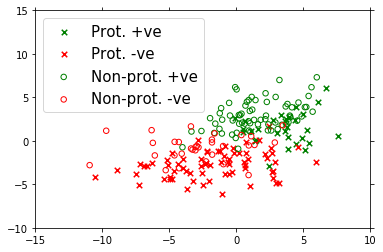

Shapes of synthetic X = (2000, 2), y=(2000,), x_sensitive=(2000,)


In [9]:
sample_count=1000
X_s, y_s , x_control_s = load_synthetic_data(load_data_size=sample_count, plot_data=True)

P-rule is: 48%
C=1,None
elif self.C and not self.fairness:
c 1
C 1
w=[0.2861232088580081, 0.6288696463550654]
b=0.12980360584316017
Accuracy for custom svm classifier, constraints = None: 0.877, c_value=1
P-rule is: 41%
Accuracy(svm) for constraints = None: 0.8785
****************************************************************************************************
C=1,Fairness Constraints
Inside if self.fairness and self.C:
c 1
C 1
w=[0.058456898753505016, 0.2013641699193549]
b=0.017811237113286537
Accuracy for custom svm classifier, constraints = Fairness Constraints: 0.878, c_value=1
P-rule is: 37%
Accuracy(svm) for constraints = Fairness Constraints: 0.8785
P-rule is: 41%
****************************************************************************************************


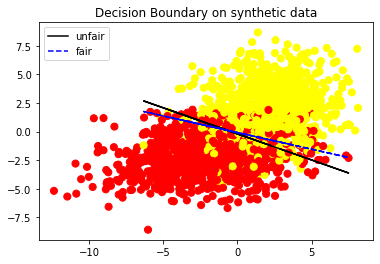

P-rule is: 48%
C=1,None
elif self.C and not self.fairness:
c 0.8
C 1
w=[0.2861232088580081, 0.6288696463550654]
b=0.12980360584316017
Accuracy for custom svm classifier, constraints = None: 0.877, c_value=0.8
P-rule is: 41%
Accuracy(svm) for constraints = None: 0.8785
****************************************************************************************************
C=1,Fairness Constraints
Inside if self.fairness and self.C:
c 0.8
C 1
w=[0.046765513575177664, 0.16109133325795533]
b=0.006177241394249774
Accuracy for custom svm classifier, constraints = Fairness Constraints: 0.8785, c_value=0.8
P-rule is: 37%
Accuracy(svm) for constraints = Fairness Constraints: 0.8785
P-rule is: 41%
****************************************************************************************************


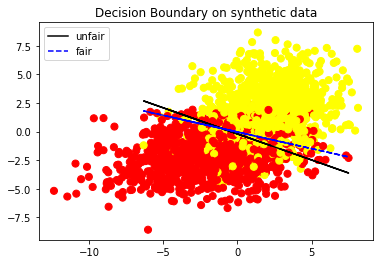

P-rule is: 48%
C=1,None
elif self.C and not self.fairness:
c 0.5
C 1
w=[0.2861232088580081, 0.6288696463550654]
b=0.12980360584316017
Accuracy for custom svm classifier, constraints = None: 0.877, c_value=0.5
P-rule is: 41%
Accuracy(svm) for constraints = None: 0.8785
****************************************************************************************************
C=1,Fairness Constraints
Inside if self.fairness and self.C:
c 0.5
C 1
w=[0.029228437894929016, 0.10068207875123214]
b=-0.011273752611676584
Accuracy for custom svm classifier, constraints = Fairness Constraints: 0.8805, c_value=0.5
P-rule is: 37%
Accuracy(svm) for constraints = Fairness Constraints: 0.8785
P-rule is: 41%
****************************************************************************************************


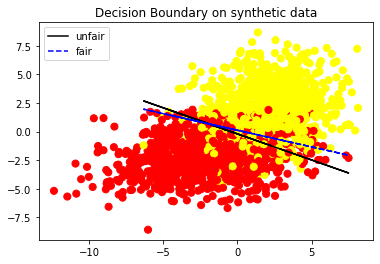

P-rule is: 48%
C=1,None
elif self.C and not self.fairness:
c 0.1
C 1
w=[0.2861232088580081, 0.6288696463550654]
b=0.12980360584316017
Accuracy for custom svm classifier, constraints = None: 0.877, c_value=0.1
P-rule is: 41%
Accuracy(svm) for constraints = None: 0.8785
****************************************************************************************************
C=1,Fairness Constraints
Inside if self.fairness and self.C:
c 0.1
C 1
w=[0.005845693728019796, 0.02013641901044494]
b=-0.03454174661328301
Accuracy for custom svm classifier, constraints = Fairness Constraints: 0.8225, c_value=0.1
P-rule is: 31%
Accuracy(svm) for constraints = Fairness Constraints: 0.8785
P-rule is: 41%
****************************************************************************************************


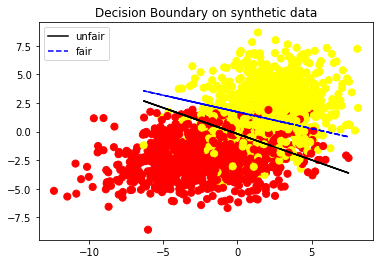

P-rule is: 48%
C=1,None
elif self.C and not self.fairness:
c 0.08
C 1
w=[0.2861232088580081, 0.6288696463550654]
b=0.12980360584316017
Accuracy for custom svm classifier, constraints = None: 0.877, c_value=0.08
P-rule is: 41%
Accuracy(svm) for constraints = None: 0.8785
****************************************************************************************************
C=1,Fairness Constraints
Inside if self.fairness and self.C:
c 0.08
C 1
w=[0.004676554982285808, 0.01610913520825008]
b=-0.035705146169540306
Accuracy for custom svm classifier, constraints = Fairness Constraints: 0.78, c_value=0.08
P-rule is: 28%
Accuracy(svm) for constraints = Fairness Constraints: 0.8785
P-rule is: 41%
****************************************************************************************************


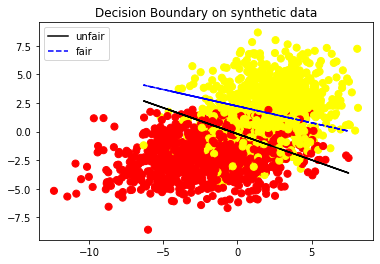

P-rule is: 48%
C=1,None
elif self.C and not self.fairness:
c 0.05
C 1
w=[0.2861232088580081, 0.6288696463550654]
b=0.12980360584316017
Accuracy for custom svm classifier, constraints = None: 0.877, c_value=0.05
P-rule is: 41%
Accuracy(svm) for constraints = None: 0.8785
****************************************************************************************************
C=1,Fairness Constraints
Inside if self.fairness and self.C:
c 0.05
C 1
w=[0.002922846863810946, 0.010068209505028847]
b=-0.037450245503974765
Accuracy for custom svm classifier, constraints = Fairness Constraints: 0.6705, c_value=0.05
P-rule is: 24%
Accuracy(svm) for constraints = Fairness Constraints: 0.8785
P-rule is: 41%
****************************************************************************************************


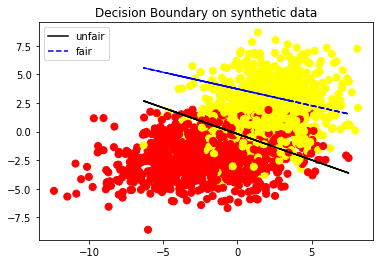

P-rule is: 48%
C=1,None
elif self.C and not self.fairness:
c 0.01
C 1
w=[0.2861232088580081, 0.6288696463550654]
b=0.12980360584316017
Accuracy for custom svm classifier, constraints = None: 0.877, c_value=0.01
P-rule is: 41%
Accuracy(svm) for constraints = None: 0.8785
****************************************************************************************************
C=1,Fairness Constraints
Inside if self.fairness and self.C:
c 0.01
C 1
w=[0.0005845693432533494, 0.0020136418815344115]
b=-0.0397770446151316
Accuracy for custom svm classifier, constraints = Fairness Constraints: 0.5, c_value=0.01
p_rule divided by 0
Accuracy(svm) for constraints = Fairness Constraints: 0.8785
P-rule is: 41%
****************************************************************************************************


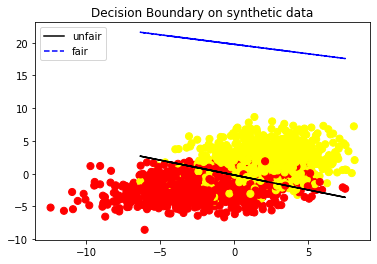

P-rule is: 48%
C=1,None
elif self.C and not self.fairness:
c 0.008
C 1
w=[0.2861232088580081, 0.6288696463550654]
b=0.12980360584316017
Accuracy for custom svm classifier, constraints = None: 0.877, c_value=0.008
P-rule is: 41%
Accuracy(svm) for constraints = None: 0.8785
****************************************************************************************************
C=1,Fairness Constraints
Inside if self.fairness and self.C:
c 0.008
C 1
w=[0.0004676554720219883, 0.0016109135035939914]
b=-0.03989338457091064
Accuracy for custom svm classifier, constraints = Fairness Constraints: 0.5, c_value=0.008
p_rule divided by 0
Accuracy(svm) for constraints = Fairness Constraints: 0.8785
P-rule is: 41%
****************************************************************************************************


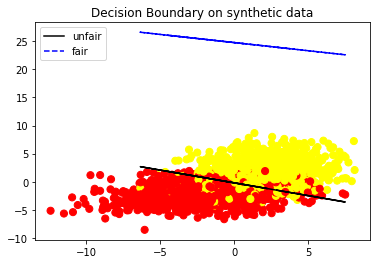

P-rule is: 48%
C=1,None
elif self.C and not self.fairness:
c 0.005
C 1
w=[0.2861232088580081, 0.6288696463550654]
b=0.12980360584316017
Accuracy for custom svm classifier, constraints = None: 0.877, c_value=0.005
P-rule is: 41%
Accuracy(svm) for constraints = None: 0.8785
****************************************************************************************************
C=1,Fairness Constraints
Inside if self.fairness and self.C:
c 0.005
C 1
w=[0.00029228465617947563, 0.0010068209311970833]
b=-0.04006789450395363
Accuracy for custom svm classifier, constraints = Fairness Constraints: 0.5, c_value=0.005
p_rule divided by 0
Accuracy(svm) for constraints = Fairness Constraints: 0.8785
P-rule is: 41%
****************************************************************************************************


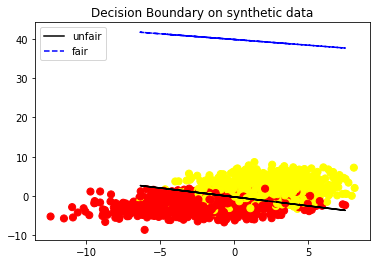

In [10]:
thresholds = [1, 0.8, 0.5, 0.1, 0.08, 0.05, 0.01] 

for correlation in thresholds: 
    # Compare the statistics of the accuracies across all cross-validation folds
    w, b, xfit, feature = run_experiment(X_s, y_s , x_control_s, [1], kernel=linear_kernel, 
                                         correlation=correlation, results=results_data)
    plot_decision_boundary(X_s, y_s, w, b, xfit)
    results_df = pd.DataFrame(results_data)

In [11]:
results_df.head(10)

,samples(train),constraints,accuracy,p_rule,accuracy_svm(Sklearn),kernel,C,coeff_c
0,2000,None,0.8770,41.405641,0.8785,linear_kernel,1,1.00
1,2000,Fairness Constraints,0.8780,37.349080,0.8785,linear_kernel,1,1.00
2,2000,None,0.8770,41.405641,0.8785,linear_kernel,1,0.80
3,2000,Fairness Constraints,0.8785,37.314664,0.8785,linear_kernel,1,0.80
4,2000,None,0.8770,41.405641,0.8785,linear_kernel,1,0.50
5,2000,Fairness Constraints,0.8805,36.598696,0.8785,linear_kernel,1,0.50
6,2000,None,0.8770,41.405641,0.8785,linear_kernel,1,0.10
7,2000,Fairness Constraints,0.8225,31.334054,0.8785,linear_kernel,1,0.10
8,2000,None,0.8770,41.405641,0.8785,linear_kernel,1,0.08
9,2000,Fairness Constraints,0.7800,27.565205,0.8785,linear_kernel,1,0.08


In [12]:
fairness_df = results_df[results_df['constraints'] == 'Fairness Constraints']
fairness_df.head()

,samples(train),constraints,accuracy,p_rule,accuracy_svm(Sklearn),kernel,C,coeff_c
1,2000,Fairness Constraints,0.8780,37.349080,0.8785,linear_kernel,1,1.00
3,2000,Fairness Constraints,0.8785,37.314664,0.8785,linear_kernel,1,0.80
5,2000,Fairness Constraints,0.8805,36.598696,0.8785,linear_kernel,1,0.50
7,2000,Fairness Constraints,0.8225,31.334054,0.8785,linear_kernel,1,0.10
9,2000,Fairness Constraints,0.7800,27.565205,0.8785,linear_kernel,1,0.08


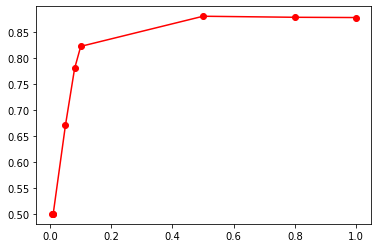

In [13]:
plt.plot(thresholds, fairness_df.accuracy, '-ro');

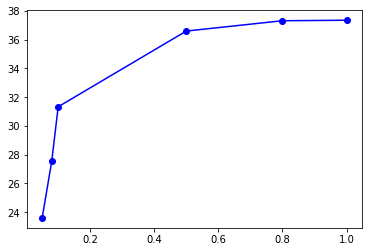

In [14]:
plt.plot(thresholds, fairness_df.p_rule, '-bo');

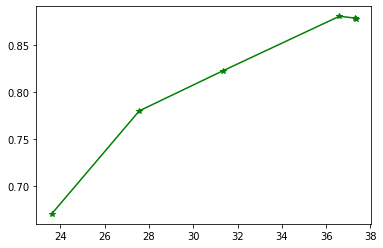

In [15]:
plt.plot(fairness_df.p_rule, fairness_df.accuracy, '-g*');